In [63]:
from pathlib import Path

MAX_DATA_PATH = Path("C:/Users/maxpd/Desktop/483 ML/Intrusion Detection/483-final-project-datasets/OPCUA_dataset_public.csv")
CHRIS_DATA_PATH = Path("/Users/chriszinati/Desktop/CPSC-483/final project datasets/483-final-project-datasets/OPCUA_dataset_public.csv")

**Data Cleaning**
- delete rows with missing data
- get rid of noisy data (in our case, all non-ddos anomalies)
- drop the multiclass target label (since were only looking at ddos vs normal (1 or 0))
- dropped source and destination ip and port (useless features)

In [64]:
import pandas as pd
#Stops showing values in scientific notation
pd.set_option('display.float_format', lambda x: f'{x:.4f}')


#it isn't reading just the relative path for some reason, so use the whole path
df = pd.read_csv(MAX_DATA_PATH)
df = df.dropna(axis=0) #drop rows with missing values

instancesToDrop= ['MITM', 'Impersonation'] 
df = (df[df.multi_label.isin(instancesToDrop) == False]) #drop instances of MITM and Impersonation
df = df.drop('multi_label', axis=1) #drop multiclass label
df = df.drop('src_ip', axis=1) #drop source ip label
df = df.drop('src_port', axis=1) #drop source port label
df = df.drop('dst_ip', axis=1) #drop destination ip label
df = df.drop('dst_port', axis=1) #drop destination port label
print(df) #should be 107578 rows x 26 columns insetead of  107634 rows x 32 columns now



        flags  pktTotalCount  octetTotalCount   avg_ps  proto  \
0           1              2              219 109.5000  OPCUA   
1           1              2              219 109.5000  OPCUA   
2           1              2              399 199.5000  OPCUA   
3           1              2              399 199.5000  OPCUA   
4           1              2              219 109.5000  OPCUA   
...       ...            ...              ...      ...    ...   
107628      1              2              359 179.5000  OPCUA   
107629      1              2              358 179.0000  OPCUA   
107630      1              2              359 179.5000  OPCUA   
107631      1              2              359 179.5000  OPCUA   
107632      1              2              359 179.5000  OPCUA   

                   service  service_errors  status_errors  msg_size  \
0       StartRawConnection               0              0        87   
1       StartRawConnection               0              0        87   
2     

In [65]:
#balancing the data, 50/50 anomaly and normal
label_0 = df[df['label'] == 0]
label_1 = df[df['label'] == 1]
label_0_samples = label_0.sample(n = 33000, random_state= 42)
label_1_samples = label_1.sample(n = 33000, random_state = 42)

balanced_df = pd.concat([label_0_samples, label_1_samples])
df_balanced = balanced_df.sample(frac = 1, random_state= 42).reset_index(drop=True)

df = df_balanced
print(df)

       flags  pktTotalCount  octetTotalCount   avg_ps  proto  \
0          1              2              359 179.5000  OPCUA   
1          0              1               86  86.0000  OPCUA   
2          0              1               86  86.0000  OPCUA   
3          1              2              359 179.5000  OPCUA   
4          0              1               86  86.0000  OPCUA   
...      ...            ...              ...      ...    ...   
65995      0              1               86  86.0000  OPCUA   
65996      1              2              358 179.0000  OPCUA   
65997      0              1               86  86.0000  OPCUA   
65998      1              2              359 179.5000  OPCUA   
65999      1              2              358 179.0000  OPCUA   

                  service  service_errors  status_errors  msg_size  \
0               Attribute               0              0       227   
1      StartRawConnection               0              0        32   
2      StartRawConnec

In [66]:
#Splitting data BEFORE further processing
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 29)

In [67]:
##Checking Correlation of all features to target label ONLY

Top features positively correlated with anomalies (label = 1):
service                        0.9988
count                          0.8704
srv_count                      0.8703
dst_host_same_src_port_rate    0.0366
same_srv_rate                  0.0363
flowInterval                  -0.1164
flowStart                     -0.3159
f_flowStart                   -0.3159
flowEnd                       -0.3159
avg_flowDuration              -0.9356
flowDuration                  -0.9356
avg_ps                        -0.9933
msg_size                      -0.9938
min_msg_size                  -0.9944
b_octetTotalCount             -0.9944
octetTotalCount               -0.9967
f_octetTotalCount             -0.9988
f_rate                        -0.9988
b_flowStart                   -0.9996
pktTotalCount                 -0.9996
b_pktTotalCount               -0.9996
flags                         -1.0000
proto                             NaN
service_errors                    NaN
status_errors            

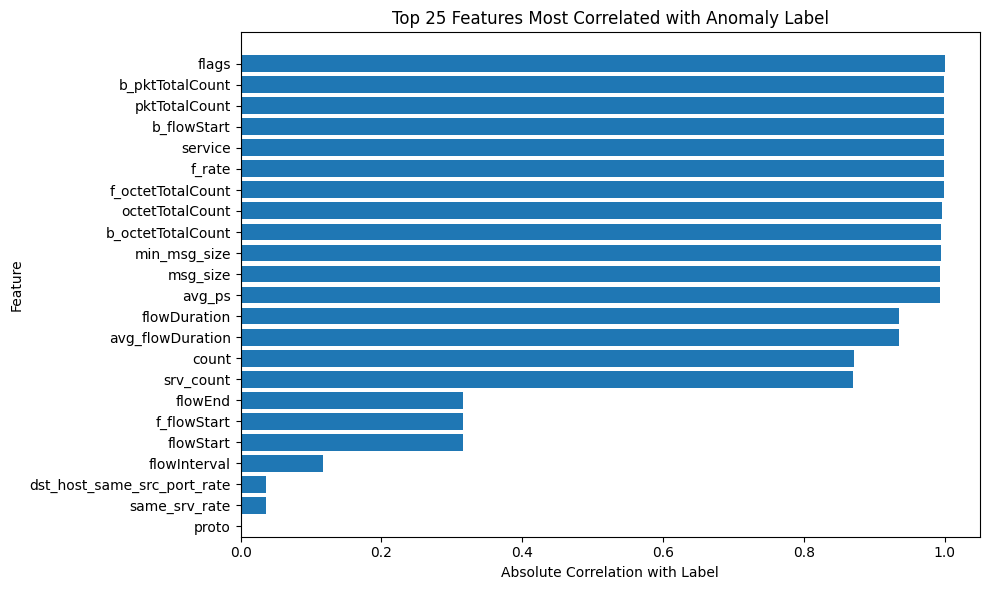

In [68]:
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder

for col in ['proto', 'service', 'service_errors', 'status_errors']:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

train_set = X_train.copy()
train_set['label'] = y_train


correlation_matrix = train_set.corr()
correlation_with_label = correlation_matrix['label'].drop('label').sort_values(ascending = False)

print("Top features positively correlated with anomalies (label = 1):")
print(correlation_with_label.head(25))

print("\nTop features negatively correlated with anomalies (label = 1):")
print(correlation_with_label.tail(25))

top_corr = correlation_with_label.abs().sort_values(ascending=False).head(25)

plt.figure(figsize=(10, 6))
plt.barh(top_corr.index, top_corr.values)
plt.gca().invert_yaxis()  # Highest on top
plt.title("Top 25 Features Most Correlated with Anomaly Label")
plt.xlabel("Absolute Correlation with Label")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [69]:
#Checking for range of all features incase normalization is needed
min_max_df = X_train.describe().loc[['min', 'max']].transpose().round(4)
print(min_max_df)

                                                 min                       max
flags                                         0.0000                    1.0000
pktTotalCount                                 1.0000                    2.0000
octetTotalCount                              86.0000                  981.0000
avg_ps                                       86.0000                  490.5000
proto                                         0.0000                    0.0000
service                                       0.0000                    3.0000
service_errors                                0.0000                    0.0000
status_errors                                 0.0000                    0.0000
msg_size                                     32.0000                  849.0000
min_msg_size                                 28.0000                  272.0000
flowStart                            1583854854.0882           1583862247.6516
flowEnd                              1583854854.0937

In [70]:
#Finding correlation between all features, checking for redudancy 

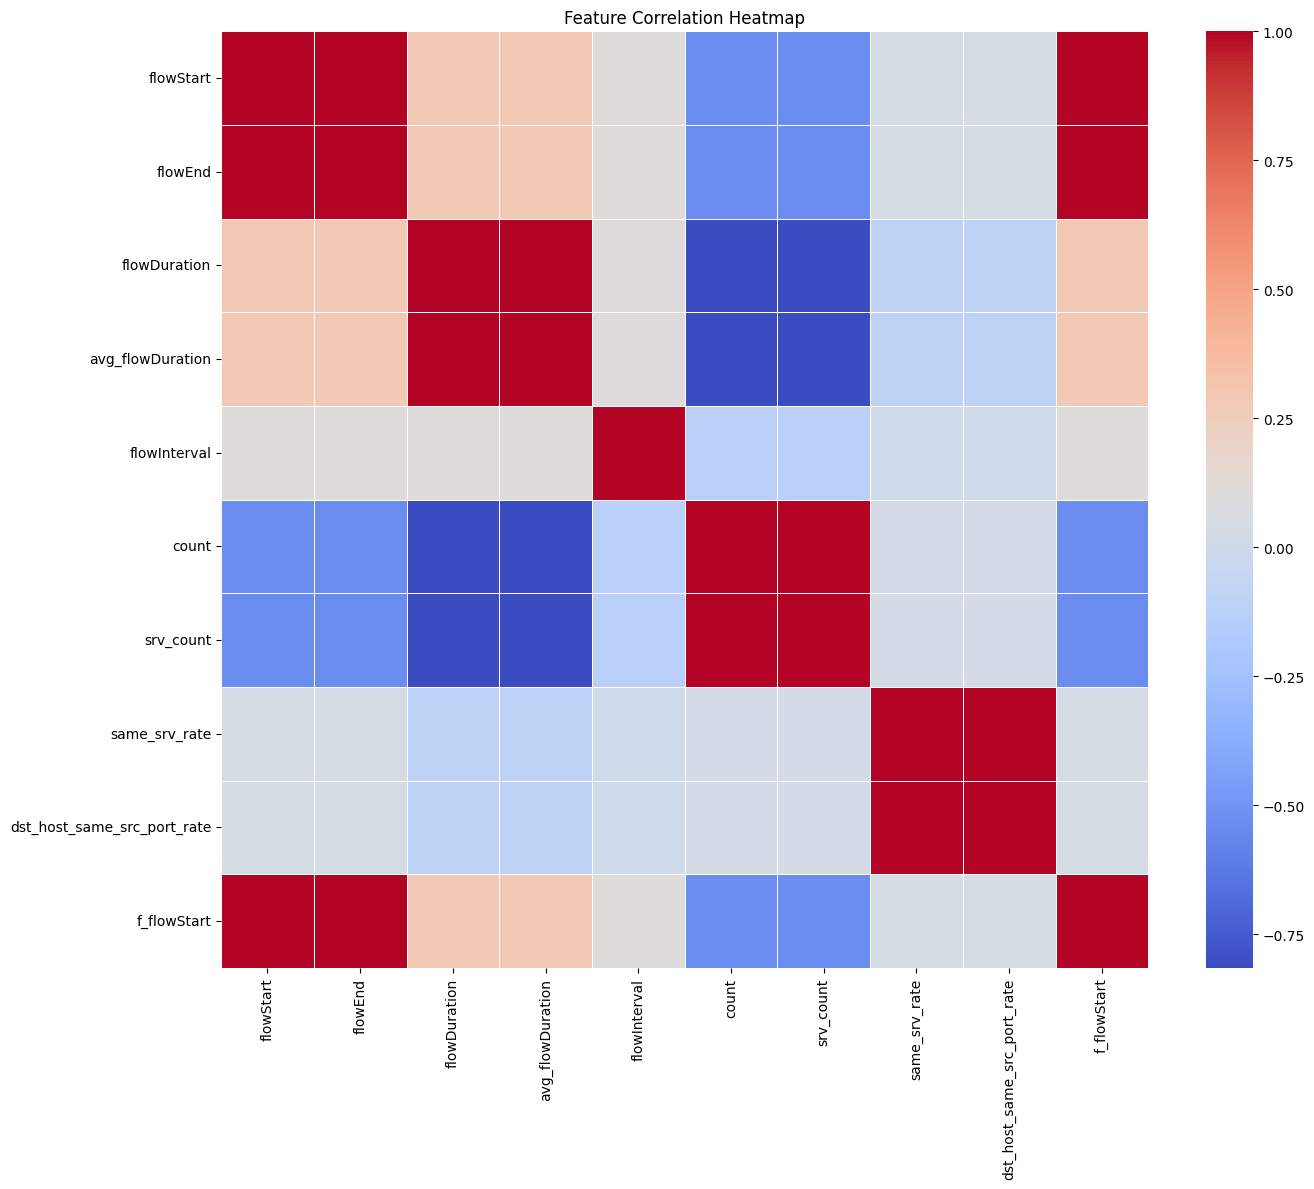

                             flowStart  flowEnd  flowDuration  \
flowStart                       1.0000   1.0000        0.2901   
flowEnd                         1.0000   1.0000        0.2901   
flowDuration                    0.2901   0.2901        1.0000   
avg_flowDuration                0.2901   0.2901        1.0000   
flowInterval                    0.1036   0.1036        0.1020   
count                          -0.5322  -0.5322       -0.8154   
srv_count                      -0.5322  -0.5322       -0.8154   
same_srv_rate                   0.0451   0.0451       -0.0998   
dst_host_same_src_port_rate     0.0455   0.0455       -0.0995   
f_flowStart                     1.0000   1.0000        0.2901   

                             avg_flowDuration  flowInterval   count  \
flowStart                              0.2901        0.1036 -0.5322   
flowEnd                                0.2901        0.1036 -0.5322   
flowDuration                           1.0000        0.1020 -0.8154   


In [71]:
import seaborn as sns
#based on correlation matrix
features_to_drop = [
    'service', 'avg_ps', 'msg_size', 'min_msg_size', 'b_octetTotalCount',
    'octetTotalCount', 'f_octetTotalCount', 'f_rate', 'b_flowStart',
    'pktTotalCount', 'b_pktTotalCount', 'flags', 'proto', 'service_errors', 'status_errors', 'f_pktTotalCount'
]

X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

corr_matrix = X_train.corr().round(4)

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
print(corr_matrix)

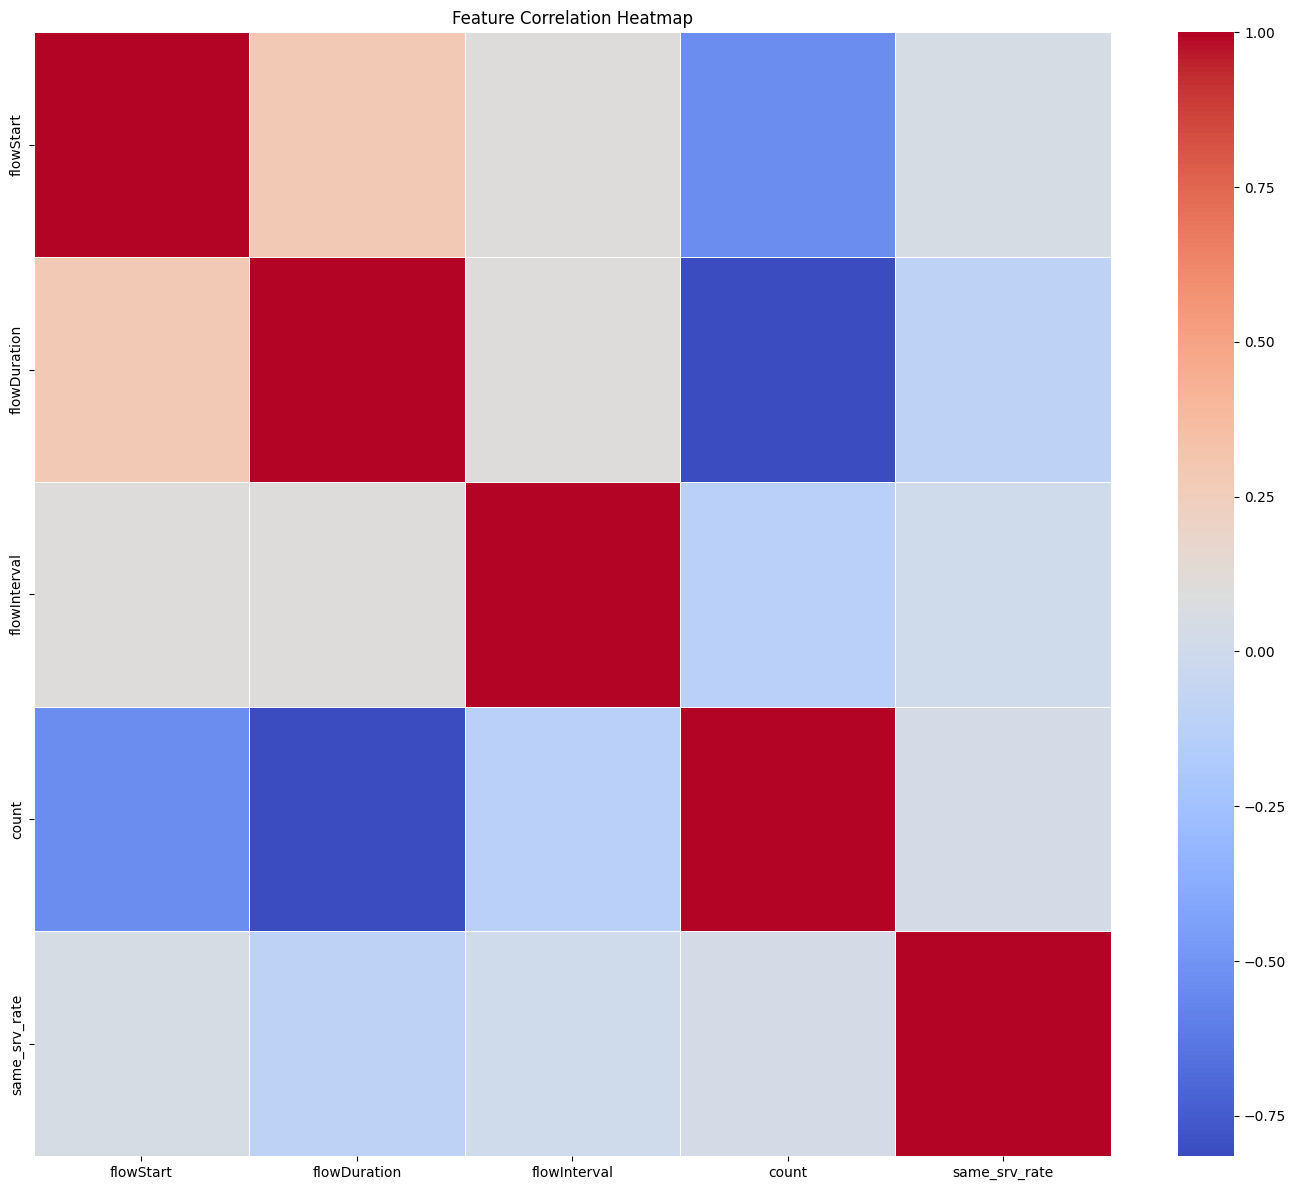

               flowStart  flowDuration  flowInterval   count  same_srv_rate
flowStart         1.0000        0.2901        0.1036 -0.5322         0.0451
flowDuration      0.2901        1.0000        0.1020 -0.8154        -0.0998
flowInterval      0.1036        0.1020        1.0000 -0.1245         0.0042
count            -0.5322       -0.8154       -0.1245  1.0000         0.0339
same_srv_rate     0.0451       -0.0998        0.0042  0.0339         1.0000


In [72]:
#handled dimensionality, still handling further
features_to_drop_again = ['flowEnd', 'avg_flowDuration', 'f_flowStart', 'srv_count', 'dst_host_same_src_port_rate']

X_train = X_train.drop(columns=features_to_drop_again)
X_test = X_test.drop(columns=features_to_drop_again)

corr_matrix = X_train.corr().round(4)

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
print(corr_matrix)

In [74]:
#view ranges of kept features 

min_max_df = X_train.describe().loc[['min', 'max']].transpose().round(4)
print(min_max_df)

                          min             max
flowStart     1583854854.0882 1583862247.6516
flowDuration           0.0000          0.0656
flowInterval          -0.0000        358.0538
count                  0.0000       1216.0000
same_srv_rate          0.0000        100.0000


In [75]:
#normalize features to common scale, using min-max scaling
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

X_train_normalized['label'] = y_train.values
X_test_normalized['label'] = y_test.values
print(X_train_normalized.describe().loc[['min','max']].transpose())





                   min      max
flowStart      -1.2421   2.5438
flowDuration   -0.9375  13.3516
flowInterval   -0.1414 190.7503
count          -0.9474   3.4384
same_srv_rate -27.6095   0.0363
label           0.0000   1.0000



Explained variance ratio for each principal component (all components):
  Component 1: 0.9859
  Component 2: 0.0141
  Component 3: 0.0000
  Component 4: 0.0000
  Component 5: 0.0000

Cumulative explained variance for all components:
  Up to Component 1: 0.9859
  Up to Component 2: 1.0000
  Up to Component 3: 1.0000
  Up to Component 4: 1.0000
  Up to Component 5: 1.0000

Minimum number of components to explain at least 95% variance: 1
Explained variance ratio for these selected components:
  Component 1: 0.9859


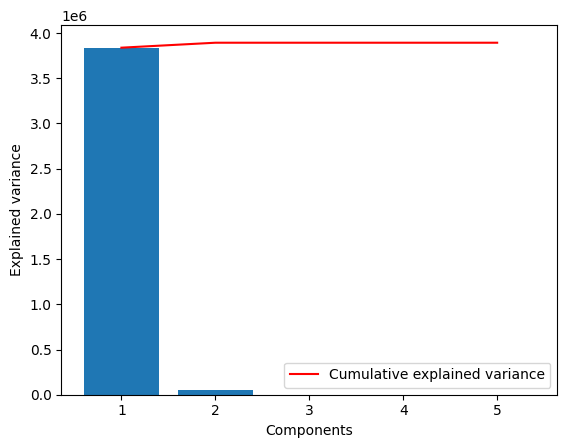

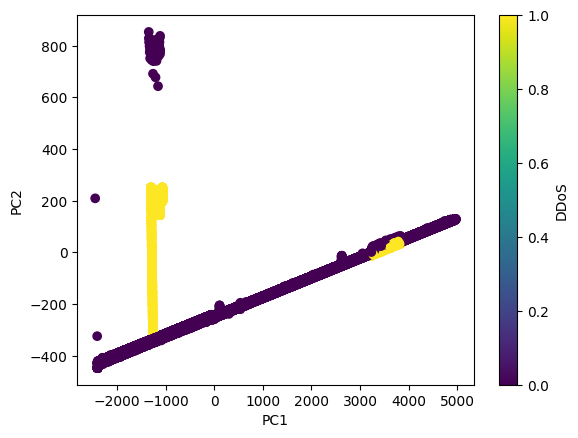

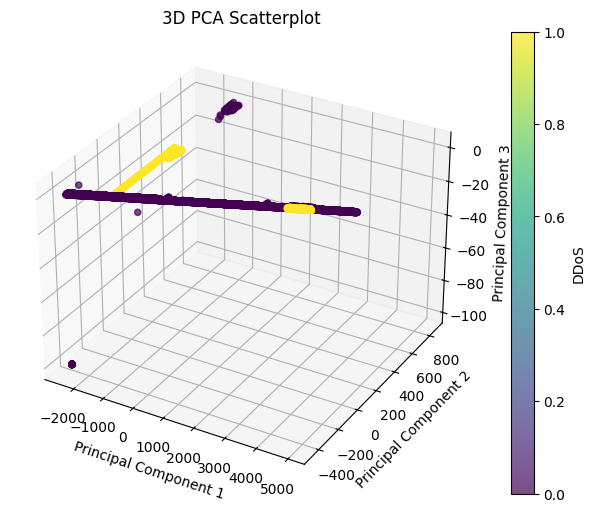

In [76]:
#apply PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

pca1 = PCA()
pca2 = PCA(0.95)
X_pca1 = pca1.fit_transform(X_train)
X_pca2 = pca2.fit_transform(X_train)

print("\nExplained variance ratio for each principal component (all components):")
for i, ratio in enumerate(pca1.explained_variance_ratio_, start=1):
    print(f"  Component {i}: {ratio:.4f}")

cumulative_variance = np.cumsum(pca1.explained_variance_ratio_)
print("\nCumulative explained variance for all components:")
for i, cumulative in enumerate(cumulative_variance, start=1):
    print(f"  Up to Component {i}: {cumulative:.4f}")

print(f"\nMinimum number of components to explain at least 95% variance: {pca2.n_components_}")
print("Explained variance ratio for these selected components:")
for i, ratio in enumerate(pca2.explained_variance_ratio_, start=1):
    print(f"  Component {i}: {ratio:.4f}")

plt.figure()
plt.bar(range(1, len(pca1.explained_variance_)+1),pca1.explained_variance_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(pca1.explained_variance_)+1),
         np.cumsum(pca1.explained_variance_),
         c='red',
         label="Cumulative explained variance")
plt.legend(loc='lower right')
plt.show()

pca2c = PCA(n_components=2)
pca3c = PCA(n_components=3)
X_pca2c = pca2c.fit_transform(X_train)
X_pca3c = pca3c.fit_transform(X_train)

plt.figure()
scatter = plt.scatter(X_pca2c[:, 0], X_pca2c[:, 1], c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='DDoS')
plt.show()


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter3d = ax.scatter(X_pca3c[:, 0], X_pca3c[:, 1], X_pca3c[:, 2], c=y_train, cmap='viridis', alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Scatterplot')
fig.colorbar(scatter3d, ax=ax, label='DDoS')
plt.show()



Key features for PC1 :
flowStart       0.9971
count           0.0764
flowInterval    0.0001
same_srv_rate   0.0001
flowDuration    0.0000
Name: PC1, dtype: float64 



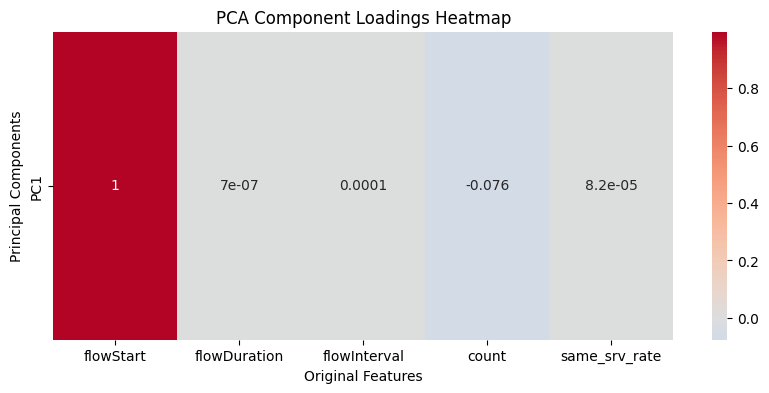

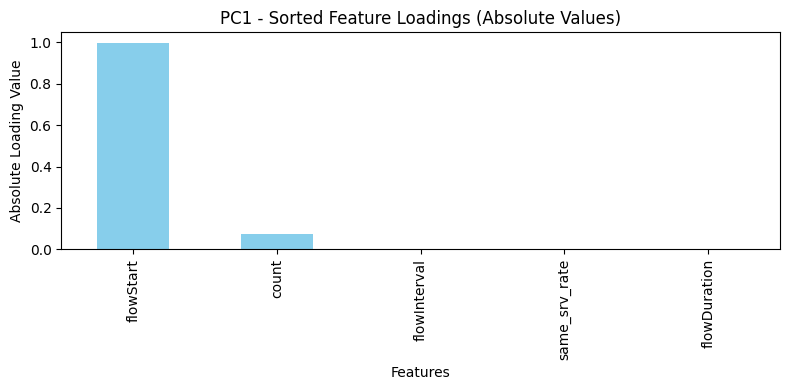

In [77]:
"""
PCA loadings are the coefficients of the linear combination of 
the original variables from which the principal components (PCs) are constructed.
describe how much each variable contributes to a particular principal component. 
Large loadings (positive or negative) indicate that a particular variable strongly 
relates to a particular principal component.
"""

component_labels = [f'PC{i+1}' for i in range(pca2.n_components_)]
loadings_df = pd.DataFrame(pca2.components_, columns=X_train.columns, index=component_labels)


# For each pc sort features by absolute loading values
for pc in loadings_df.index:
    sorted_loadings = loadings_df.loc[pc].abs().sort_values(ascending=False)
    print(f"Key features for {pc} :")
    print(sorted_loadings, "\n")

#heatmap for a visual interpretation of the loadings
plt.figure(figsize=(10, 4))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Component Loadings Heatmap")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()

#bar charts for each principal component's loadings
for pc in loadings_df.index:
    plt.figure(figsize=(8, 4))
    sorted_features = loadings_df.loc[pc].abs().sort_values(ascending=False)
    sorted_features.plot(kind='bar', color='skyblue')
    plt.title(f"{pc} - Sorted Feature Loadings (Absolute Values)")
    plt.xlabel("Features")
    plt.ylabel("Absolute Loading Value")
    plt.tight_layout()
    plt.show()

In [78]:
# Save features and labels separately
X_train.to_csv("X_train_preprocessed.csv", index=False)
X_test.to_csv("X_test_preprocessed.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
